In [1]:
import numpy as np
import pandas as pd
import time
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import geopandas as gpd
from shapely.geometry import Point, MultiPoint
import contextily as cx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from joblib import dump, load, Memory
from feature_engine.datetime import DatetimeFeatures

In [2]:
rides_clean = pd.read_csv("data/rides_train_clean.csv", parse_dates=['started_at', 'ended_at', 'start_hour', 'end_hour'])

In [ ]:
def get_bike_counts(rides_df, grp_cols, cols):
    """aggregate bike counts in rides_df by grp_cols, and take the averages in all other cols"""

    agg_dict = {c: 'mean' for c in cols}
    if 'duration_mins' in agg_dict:
        agg_dict['duration_mins'] = 'median'  # use median instead for duration

    bike_counts = rides_df.groupby(grp_cols)[cols].agg(agg_dict).reset_index()
    temp_count = rides_df.groupby(grp_cols)[cols[0]].count().reset_index().rename(columns={cols[0]: 'rides'})
    bike_counts = pd.merge(left=bike_counts, right=temp_count, how='inner', on=grp_cols)
    return bike_counts, temp_count

In [ ]:
dtfs = DatetimeFeatures(
                variables='time',
                features_to_extract=["year", "quarter", "month",
                                     "hour", "day_of_week", "weekend"],
                drop_original=False,
    )

### Net rides

In [ ]:
cols = ['start_docked']
ride_counts_out, _ = get_bike_counts(rides_clean, ['start_hour', 'start_station_id'], cols)
ride_counts_out = ride_counts_out.rename(columns={'start_hour': 'time', 'start_station_id':'station_id'})

ride_counts_in, _ = get_bike_counts(rides_clean, ['end_hour', 'end_station_id'], cols)
ride_counts_in = ride_counts_in.rename(columns={'end_hour': 'time', 'end_station_id':'station_id'})

In [ ]:
ride_counts = pd.merge(ride_counts_out,
                       ride_counts_in,
                       on=('time', 'station_id'),
                       how='outer',
                       suffixes = ('_out', '_in'),
                      ).drop(['start_docked_out', 'start_docked_in'], axis=1).fillna(0)
ride_counts['net_rides'] = ride_counts['rides_in'] - ride_counts['rides_out']

#### connectivity

In [5]:
rides_clean[['start_station_id', 'end_station_id']] = rides_clean[['start_station_id', 'end_station_id']].astype(int)


rides_conn = rides_clean.copy()
rides_conn['hour'] = rides_conn['start_hour'].dt.hour
rides_conn['weekend'] = rides_conn['start_hour'].dt.dayofweek>5

#rides_conn = rides_conn.groupby(
#    ['hour', 'weekend', 'start_station_id', 'end_station_id'])['start_docked'].mean().reset_index()

rides_conn = rides_conn.groupby(
    ['start_station_id', 'end_station_id'])['start_docked'].value_counts().reset_index()
rides_conn = rides_conn.pivot(index="start_station_id", columns="end_station_id", values="count").fillna(0)

rides_conn = rides_conn / rides_conn.max(axis=0)

In [6]:
(rides_clean['start_station_id']==rides_clean['end_station_id']).sum() / len(rides_clean)

0.06232420626305651

In [7]:
station_coords = rides_clean[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates(
    subset='start_station_id')

station_coords = station_coords.set_index('start_station_id')

# Get the list of station names and their corresponding coordinates
station_names = station_coords.index
#station_coords = np.array(list(station_coords.values))

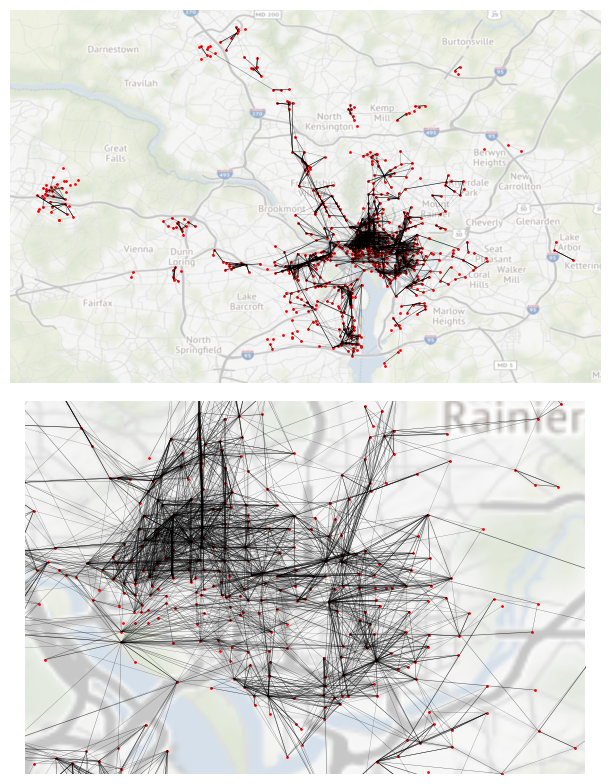

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

for ix, ax in enumerate(axs):
    for end_station in station_names:
        station_rides = rides_conn.loc[:, end_station]  # all rides end at that station
        start_stations = rides_conn.index[station_rides > 0.3]
        station_rides = station_rides[station_rides > 0.3]

        end_coords = station_coords.loc[end_station]
        for start_station in start_stations:
            start_coords = station_coords.loc[start_station]
            thickness = rides_conn.loc[start_station, end_station]
            
            if ix==1:
                ax.plot([start_coords[1], end_coords[1]], [start_coords[0], end_coords[0]],
                             linewidth=thickness*0.4, color='black', alpha=0.7)
            else:
                ax.plot([start_coords[1], end_coords[1]], [start_coords[0], end_coords[0]],
                             linewidth=thickness*0.4, color='black', alpha=thickness)
                
    # Plot the stations as points
    ax.scatter(station_coords["start_lng"], station_coords["start_lat"],
               c='red', s=1)

    cx.add_basemap(ax, crs='EPSG:4326', alpha=0.4, attribution=False)
    ax.axis('off')
    #ax.set_aspect('equal', adjustable='box')

axs[1].set_xlim(-77.07, -76.95)
axs[1].set_ylim(38.86, 38.94)
#axs[1].set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.savefig("figs/station_connectivity2.png", format="png", bbox_inches="tight", transparent=True)
plt.show()

<Axes: xlabel='end_station_id', ylabel='start_station_id'>

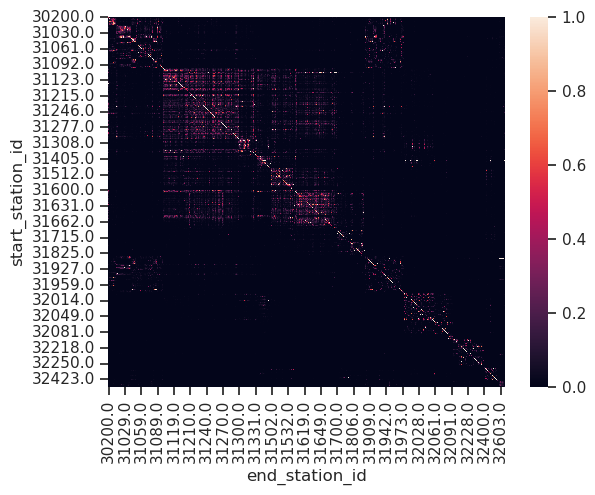

In [86]:
sns.heatmap(data=rides_conn)

In [102]:
# repeat for morning and evening rush hours specifically

rides_conn = rides_clean.copy()
rides_conn['hour'] = rides_conn['start_hour'].dt.hour
rides_conn['weekend'] = rides_conn['start_hour'].dt.dayofweek>5

rush_am = (rides_conn['hour']>5) & (rides_conn['hour']<10) & (~rides_conn['weekend'])
rush_pm = (rides_conn['hour']>15) & (rides_conn['hour']<20) & (~rides_conn['weekend'])

rides_am = rides_conn.loc[rush_am, :].groupby(
    ['start_station_id', 'end_station_id'])['start_docked'].value_counts().reset_index()
rides_am = rides_am.pivot(index="start_station_id", columns="end_station_id", values="count").fillna(0)
rides_am = rides_am / rides_am.max(axis=0)

rides_pm = rides_conn.loc[rush_pm, :].groupby(
    ['start_station_id', 'end_station_id'])['start_docked'].value_counts().reset_index()
rides_pm = rides_pm.pivot(index="start_station_id", columns="end_station_id", values="count").fillna(0)
rides_pm = rides_pm / rides_pm.max(axis=1)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), sharey=True)
sns.heatmap(data=rides_am, ax=ax[0], square=True, vmin=0, vmax=1)
sns.heatmap(data=rides_pm, ax=ax[1], square=True, vmin=0, vmax=1)
plt.show()